In [146]:
## prepare data

In [11]:
%matplotlib inline
import pandas as pd; import numpy as np 
import os
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import warnings
from functools import reduce
import importlib
from tools import write_file
import multiprocessing
import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/Users/jerryliu/jerry_jupyter/internship/tools.py'>

In [2]:
#load four mutation files.
path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/mutation_files/'
file_list = ['damaging','hotspot','nonconserving','otherconserving']
drug_path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/primary-screen-replicate-collapsed-logfold-change.csv'
out_path = '/Users/jerryliu/jerry_jupyter/internship/output/'

In [3]:
#read drug sensitivity files. 
def read_drug(drug_path):
    drug_data = pd.read_csv(drug_path)
    drug_data = drug_data.set_index(drug_data.columns[0])
    return(drug_data)

In [4]:
#funtion to merge two mutation files.
def merge_mt(m_f1, m_f2, drug_id, gene_filter = False):
    # input: dataframe with index as cell line id. 
    # output: merged dataframe
    #cell lines: m_f1 & m_f2;  cancer genes: m_f1 | m_f2.
    if not gene_filter:
        cl_id = set.intersection(set(m_f1.index), set(m_f2.index), set(drug_id))
    else:
        cl_id = set.intersection(set(m_f1.index), set(m_f2.index))
        
    gene_id = set.union(set(m_f1.columns), set(m_f2.columns))

    m_f1 = m_f1.reindex(cl_id, columns = gene_id, fill_value = 0 )
    m_f2 = m_f2.reindex(cl_id, columns = gene_id, fill_value = 0)
    #combine the two files.
    m_comb = pd.DataFrame(np.where(m_f1 == 0, m_f2, m_f1), index = cl_id, columns=gene_id)
    
    return(m_comb)

In [5]:
def filter_genes(file, thresh = 0.1):
    """
    thresh: at least ## of cell lines are mutated and are kept. 
    input: list of dataframes of mutated genes.
    output: list of most mutated genes. 
    """
    gene_bool = file.apply(lambda x: True if (x == 1).sum()/len(x) >= thresh else False).values
    return(file.columns[gene_bool])
    

In [15]:

def EN_cv_in(x_train, y_train, fold, alpha, l1_ratio):
        """
        input: training set. (each alpha, l1_ratio parameter)
        output: averge spearman correlation score of 10 results
        """
        #alpha = p1, l1_ratio = p2
        kf_in = KFold(n_splits = fold)
        cv_perf = np.array([]) 
        for train_in, test_in in kf_in.split(x_train):

            x_train_in, x_test_in, y_train_in, y_test_in = x_train[train_in], x_train[test_in], y_train[train_in], y_train[test_in]

            #build model with each combination of parameters. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                regr = ElasticNet(random_state = 0, alpha= alpha, l1_ratio=l1_ratio, fit_intercept = False)
                regr.fit(x_train_in, y_train_in)
                
            y_pre = regr.predict(x_test_in)
            #perforamance matrix of the model is the Pearson's corrlation coeeficient r. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                r = pd.Series(y_pre).corr(pd.Series(y_test_in), method = 'spearman')
                cv_perf = np.append(cv_perf,[r])
                del regr
        return(np.mean(cv_perf))

    
def out_loop (x, y_total, cl_id, out_cv_fold= 5):
    ''' 5 fold cv (outter-loop)
    # x: (#_(80%)C, #_genes); y: (#_(80%)C,)
    '''
    kf = KFold(n_splits = out_cv_fold)
    pre_y_array = dict(list(zip(cl_id,[ [] for _ in range(len(cl_id))])))
    per_test_list = []
    for train, test in kf.split(x):
        x_train, x_test, y_train, y_test = x.values[train], x.values[test], y_total.values[train], y_total.values[test]
        train_label, test_label = x.index[train], x.index[test]
        # 10-fold in x_train (inner-loop). 
        # each pair of alpha and l1_ratio, do cross training to sellect best pair. 

        l1_ratio_list = np.linspace(start = 0.2, stop = 1.0, num = 10) #10 values
        alpha_list =  np.array([math.exp(i) for i in np.arange(-16,5,2)]) # 250 values
        #alpha_list =  np.array([math.exp(i) for i in np.arange(-8,5,0.8)]) #  values
        para_matrix = {(l1_ratio, alpha):0 for l1_ratio in l1_ratio_list for alpha in alpha_list}

        for (l1_ratio, alpha) in para_matrix:
            #do ten fold cv to sellect best parameter pairs. 
            ave_per = EN_cv_in(x_train= x_train, y_train = y_train, fold = 10, alpha = alpha, l1_ratio= l1_ratio)
            para_matrix[(l1_ratio, alpha)] = ave_per
        print(para_matrix)
        
        #return the best alpha-l1-ratio pair.
        op_l1_ratio, op_alpha = pd.Series(para_matrix).idxmax() 
        print('the best validation performance is: ', para_matrix[(op_l1_ratio, op_alpha)])
        
        #predict on the 5th-fold set (testing set)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            regr = ElasticNet(random_state=0, alpha= op_alpha, l1_ratio = l1_ratio, fit_intercept = False)
            regr.fit(x_train, y_train)
            y_pre = regr.predict(x_test)
            
        if len(np.unique(y_pre) ) == 1: print('constant prediction.')
        del regr
        #add results to the storage dictionary. 
        for index, value in zip(test_label, y_pre): pre_y_array[index].append(value)
        per_test = pd.Series(y_pre).corr(pd.Series(y_test),method = 'spearman') 
        per_test_list.append(per_test)
        print('performance on the test set is:', per_test)
        plt.scatter(y_test, y_pre)
        plt.xlabel('test set')
        plt.ylabel('prediction')
        plt.show()
        #break
    #add the prediction to the list.
    pre_y_array = pd.Series(pre_y_array).reindex(cl_id)
    
    return(pre_y_array, per_test_list)

def drug_model(comp_index, m_file,  drug_data, out_path):
    """
    input: m_file mutation matrix with unpreprocessed binery values.
    output: mean prediction values of 10 iterations in pd.Sereis type.
    """
    #eliminate cell lines with nan dryg sensitivity data.
    #comp_index = 0
#     print(comp_index)
#     print(m_file.shape)
    
    valid_cl_index = drug_data.loc[m_file.index,:].iloc[:,comp_index].dropna().index
    Y = drug_data.iloc[:, comp_index][valid_cl_index]
    drug_name = drug_data.columns[comp_index]
    print('drug_name is: ',drug_name)
    print('number of missing values in Y: ', Y.isnull().sum())
    m_file_notna = m_file.loc[valid_cl_index,:]
    
    #normalize the each col to have ~0 mean and ~1 sd. 
    norm_m_file = (m_file_notna - m_file_notna.mean(axis = 0)) / m_file_notna.std(axis = 0)
    print(norm_m_file.sum())
    
    print('### normalize with mean=0, std = 1.')
    norm_m_file.dropna(axis = 1, inplace = True)
    
#     #Use features that have pearson correlation with Y over 0.1.
#     cor_number = norm_m_file.corrwith(Y, axis = 0, method = 'pearson')
#     #number of genes that have correlation over 0.1
#     #sum(np.abs(cor_number) >= 0.1)
#     norm_m_file = norm_m_file.loc[:, np.abs(cor_number) >= 0.1]
#     #print('number of features selected {}'.format(sum(np.abs(cor_number) >= 0.1)))
    
    
    print('number of features selected {}'.format(norm_m_file.shape[1]))
    X, Y_total = norm_m_file, Y
    
    ### EN model
    ## bootstraping (80% of data) for 10 times. 
    ## each time with 80% data for training, 10% for cross validataion, and remaining 10% for
    ## testing.
    cl_id = norm_m_file.index
    Y_pre_array = pd.Series(dict(list(zip(cl_id, [[] for i in range(cl_id.shape[0])]))),
                            index = cl_id, name = drug_name)
    cv_result_list = []
    for i in tqdm(range(10)):
        print('iteration {} begains'.format(i))
        x, y_total = resample(X, Y_total, replace = False, n_samples = int(X.shape[0]*0.8), random_state = i)
        print(X.isna().sum().sum())
        print(y_total.isna().sum().sum())

        #outter loop with 5 fold cv.
        prediction, cv_list = out_loop(x = x, y_total= y_total, cl_id = cl_id, out_cv_fold=5 )
        cv_result_list.extend(cv_list)
        print('iter {}, outter loop finished. '.format(i))
        
        for i in prediction.index: Y_pre_array[i].extend(prediction[i])

    
    ##calculate the mean of 10 iterations. 
    Y_pre_array = Y_pre_array.map(np.mean)
    tools.write_file(Y_pre_array, 'comp_{}.csv'.format(comp_index), out_path)
    # list of cross validation results. 
    return(cv_result_list)


In [7]:
#def main():
#read data
drug_data = read_drug(drug_path = drug_path)
m_f1, m_f2, m_f3,_  = file_list
m_f1 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f1 + '.csv', index_col = 0)
m_f2 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f2 + '.csv', index_col = 0)
m_f3 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f3 + '.csv', index_col = 0)
print('#### reading files completed')

#### reading files completed


In [8]:
#merge mutation files
m_file = merge_mt(merge_mt(m_f1, m_f2, drug_id=drug_data.index), m_f3, 
                  drug_id= drug_data.index,gene_filter=False)
#m_file = m_f1.reindex(set.intersection(set(m_f1.index), set(drug_data.index)))
print('#### merge mutation files completed')
print(m_file.shape)
#filter most mutated genes. 
w_m_file = merge_mt(merge_mt(m_f1, m_f2, drug_id=drug_data.index, gene_filter=True), m_f3, 
                  drug_id= drug_data.index,gene_filter = True)

#w_m_file = m_f1
#m_file = m_f1
gene_bool = filter_genes(w_m_file, thresh=0.08)
#print(gene_bool)
m_file = m_file.loc[:,gene_bool]
print(m_file.shape)

# get rid of drugs with too many missing values.
thresh  = int(m_file.shape[0]*(1-0.1)) ## at least ## number of Non-na value in each drug
drug_id_list = drug_data.loc[m_file.index,:].dropna(axis = 1, thresh = thresh).columns
#build model for each drug.
pre_matrix = pd.Series(index = m_file.index)

# ''' multiprocessing the command '''
# n_jobs = 100
# jobs_list = tools.split_task(len(drug_id_list), n_jobs)
# drug_mapping_list = list(zip(drug_id_list, [np.where(drug_data.columns == drug_id)
# for index_array in jobs_list:
#     work_list = []
#     for job in index_array:
#         drug_name, drug_index = drug_mapping_list[job][0], int(drug_mapping_list[job][1][0])
#         p = multiprocessing.Process(target = drug_model, args = (drug_index, m_file, drug_data))
#         work_list.append(p)
#     #start the programs.
#     for job in work_list: job.start()
#     #end the programs.
#     for job in work_list: job.join()

#### merge mutation files completed
(563, 18724)
(563, 270)


<ipython-input-8-527bad823684>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_matrix = pd.Series(index = m_file.index)


  0%|          | 0/10 [00:00<?, ?it/s]

drug_name is:  BRD-A00218260-001-03-4::2.5::HTS
number of missing values in Y:  0
MGAM (8972)        -6.183942e-14
ADAMTS12 (81792)   -1.070255e-13
CEP350 (9857)      -2.053913e-14
PIEZO2 (63895)      2.609024e-14
ANKRD30A (91074)    3.963496e-14
                        ...     
APC (324)          -7.938095e-14
NOTCH3 (4854)       4.940492e-14
MUC4 (4585)         5.695444e-14
ABCA13 (154664)    -3.730349e-14
ASXL3 (80816)       1.177947e-13
Length: 270, dtype: float64
### normalize with mean=0, std = 1.
number of features selected 270
iteration 0 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.09428344310697252, (0.2, 8.315287191035679e-07): -0.09447952153834507, (0.2, 6.14421235332821e-06): -0.09486562192444545, (0.2, 4.5399929762484854e-05): -0.09344916344916346, (0.2, 0.00033546262790251185): -0.10072299189946247, (0.2, 0.0024787521766663585): -0.11368385191914605, (0.2, 0.01831563888873418): -0.14885532591414946, (0.2, 0.1353352832366127): -0.1476587416196651, (0.2, 1.0): nan, (0.2,

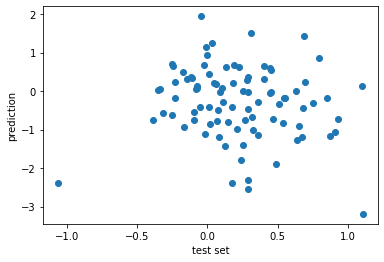

{(0.2, 1.1253517471925912e-07): -0.08030585207055796, (0.2, 8.315287191035679e-07): -0.08030585207055796, (0.2, 6.14421235332821e-06): -0.08030585207055796, (0.2, 4.5399929762484854e-05): -0.08179423120599591, (0.2, 0.00033546262790251185): -0.08876977818154289, (0.2, 0.0024787521766663585): -0.10600348247407072, (0.2, 0.01831563888873418): -0.10357559239912181, (0.2, 0.1353352832366127): -0.06486066987345016, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.08030585207055796, (0.2888888888888889, 8.315287191035679e-07): -0.08030585207055796, (0.2888888888888889, 6.14421235332821e-06): -0.080165796048149, (0.2888888888888889, 4.5399929762484854e-05): -0.08133999545764252, (0.2888888888888889, 0.00033546262790251185): -0.08592323415852829, (0.2888888888888889, 0.0024787521766663585): -0.10270724506018625, (0.2888888888888889, 0.01831563888873418): -0.09055038231508822, (0.2888888888888889, 0.1353352832366127)

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


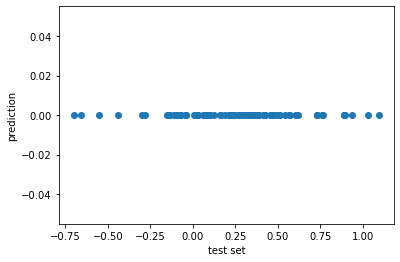

{(0.2, 1.1253517471925912e-07): -0.10558180028768265, (0.2, 8.315287191035679e-07): -0.10591793474146416, (0.2, 6.14421235332821e-06): -0.10669392081156788, (0.2, 4.5399929762484854e-05): -0.10965856612915437, (0.2, 0.00033546262790251185): -0.11236656824892119, (0.2, 0.0024787521766663585): -0.12830418653948067, (0.2, 0.01831563888873418): -0.09192671663259899, (0.2, 0.1353352832366127): 0.06677543101555787, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.10558180028768265, (0.2888888888888889, 8.315287191035679e-07): -0.10591793474146416, (0.2888888888888889, 6.14421235332821e-06): -0.10669392081156788, (0.2888888888888889, 4.5399929762484854e-05): -0.10886213945037475, (0.2888888888888889, 0.00033546262790251185): -0.11644030585207057, (0.2888888888888889, 0.0024787521766663585): -0.1260723748959043, (0.2888888888888889, 0.01831563888873418): -0.0630267242031948, (0.2888888888888889, 0.1353352832366127):

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


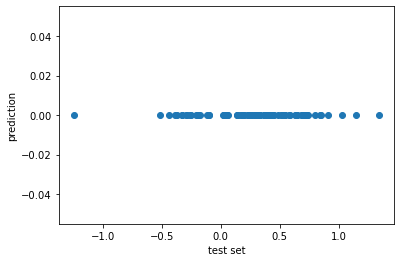

{(0.2, 1.1253517471925912e-07): -0.09785297902944963, (0.2, 8.315287191035679e-07): -0.09785297902944963, (0.2, 6.14421235332821e-06): -0.09804148686501628, (0.2, 4.5399929762484854e-05): -0.09499205087440382, (0.2, 0.00033546262790251185): -0.11469528351881293, (0.2, 0.0024787521766663585): -0.1403936709819063, (0.2, 0.01831563888873418): -0.16392838216367628, (0.2, 0.1353352832366127): -0.08215754482207392, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.09785297902944963, (0.2888888888888889, 8.315287191035679e-07): -0.09785297902944963, (0.2888888888888889, 6.14421235332821e-06): -0.09804148686501628, (0.2888888888888889, 4.5399929762484854e-05): -0.09600423953365131, (0.2888888888888889, 0.00033546262790251185): -0.11919297448709214, (0.2888888888888889, 0.0024787521766663585): -0.14722689075630252, (0.2888888888888889, 0.01831563888873418): -0.16462563403739877, (0.2888888888888889, 0.1353352832366127

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


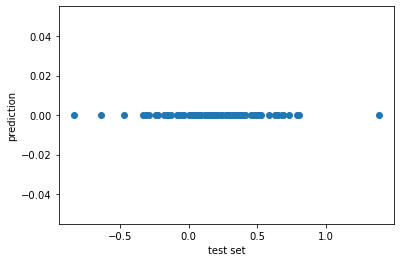

{(0.2, 1.1253517471925912e-07): -0.13049965932318874, (0.2, 8.315287191035679e-07): -0.13049965932318874, (0.2, 6.14421235332821e-06): -0.1307517601635249, (0.2, 4.5399929762484854e-05): -0.1308320084790673, (0.2, 0.00033546262790251185): -0.12764478764478768, (0.2, 0.0024787521766663585): -0.11563025210084035, (0.2, 0.01831563888873418): -0.07661897191308956, (0.2, 0.1353352832366127): -0.030193732452588246, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.13049965932318874, (0.2888888888888889, 8.315287191035679e-07): -0.13049965932318874, (0.2888888888888889, 6.14421235332821e-06): -0.1307517601635249, (0.2888888888888889, 4.5399929762484854e-05): -0.13147626618214855, (0.2888888888888889, 0.00033546262790251185): -0.13157998334468923, (0.2888888888888889, 0.0024787521766663585): -0.10895298660004542, (0.2888888888888889, 0.01831563888873418): -0.06174275115451587, (0.2888888888888889, 0.1353352832366127)

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


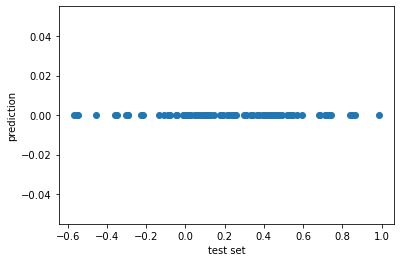

 10%|█         | 1/10 [04:34<41:10, 274.52s/it]

iter 0, outter loop finished. 
iteration 1 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.039103641456582634, (0.2, 8.315287191035679e-07): -0.039103641456582634, (0.2, 6.14421235332821e-06): -0.03862745098039216, (0.2, 4.5399929762484854e-05): -0.03865470512529338, (0.2, 0.00033546262790251185): -0.03937542584601407, (0.2, 0.0024787521766663585): -0.04472556590203649, (0.2, 0.01831563888873418): -0.06754258460140813, (0.2, 0.1353352832366127): -0.0007439132960926576, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.039103641456582634, (0.2888888888888889, 8.315287191035679e-07): -0.039103641456582634, (0.2888888888888889, 6.14421235332821e-06): -0.03862745098039216, (0.2888888888888889, 4.5399929762484854e-05): -0.039121810886516784, (0.2888888888888889, 0.00033546262790251185): -0.04018850783556666, (0.2888888888888889, 0.0024787521766663585): -0.0498758422287834, (0.2888888888888889, 0.01831563888873418):

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


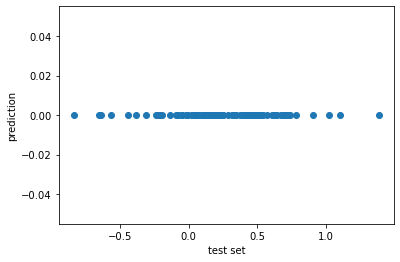

{(0.2, 1.1253517471925912e-07): -0.06668710727534258, (0.2, 8.315287191035679e-07): -0.06666136724960256, (0.2, 6.14421235332821e-06): -0.06666136724960256, (0.2, 4.5399929762484854e-05): -0.06898099780452722, (0.2, 0.00033546262790251185): -0.07143689908395792, (0.2, 0.0024787521766663585): -0.09292149292149292, (0.2, 0.01831563888873418): -0.12514951926716636, (0.2, 0.1353352832366127): -0.12062754197151102, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.06668710727534258, (0.2888888888888889, 8.315287191035679e-07): -0.06666136724960256, (0.2888888888888889, 6.14421235332821e-06): -0.06666136724960256, (0.2888888888888889, 4.5399929762484854e-05): -0.0694291770762359, (0.2888888888888889, 0.00033546262790251185): -0.07448027859792566, (0.2888888888888889, 0.0024787521766663585): -0.10472178060413354, (0.2888888888888889, 0.01831563888873418): -0.1273934438640321, (0.2888888888888889, 0.1353352832366127)

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


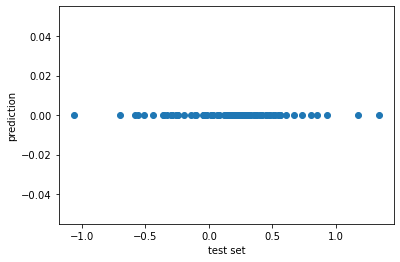

{(0.2, 1.1253517471925912e-07): 0.0016216216216216272, (0.2, 8.315287191035679e-07): 0.001761677644030596, (0.2, 6.14421235332821e-06): 0.002630024982966167, (0.2, 4.5399929762484854e-05): 0.00526686350215762, (0.2, 0.00033546262790251185): 0.003840563252327961, (0.2, 0.0024787521766663585): -0.025310015898251194, (0.2, 0.01831563888873418): -0.03603376485729427, (0.2, 0.1353352832366127): 0.08994346193424131, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.0016216216216216272, (0.2888888888888889, 8.315287191035679e-07): 0.001761677644030596, (0.2888888888888889, 6.14421235332821e-06): 0.002630024982966167, (0.2888888888888889, 4.5399929762484854e-05): 0.0044855780149897825, (0.2888888888888889, 0.00033546262790251185): 0.0026027708380649663, (0.2888888888888889, 0.0024787521766663585): -0.029330002271178747, (0.2888888888888889, 0.01831563888873418): -0.03895980013627072, (0.2888888888888889, 0.13533528323

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


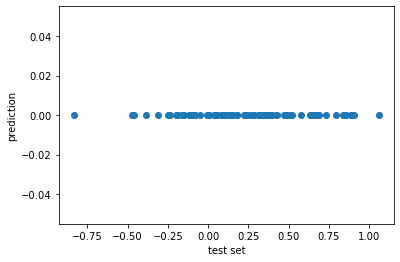

{(0.2, 1.1253517471925912e-07): -0.04674615792262852, (0.2, 8.315287191035679e-07): -0.04674615792262852, (0.2, 6.14421235332821e-06): -0.04666893784540844, (0.2, 4.5399929762484854e-05): -0.04885532591414945, (0.2, 0.00033546262790251185): -0.04277538042243925, (0.2, 0.0024787521766663585): -0.023483231130289953, (0.2, 0.01831563888873418): -0.024387917329093796, (0.2, 0.1353352832366127): -0.0013719212485561489, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.04674615792262852, (0.2888888888888889, 8.315287191035679e-07): -0.04674615792262852, (0.2888888888888889, 6.14421235332821e-06): -0.04686501627678098, (0.2888888888888889, 4.5399929762484854e-05): -0.04839200545082899, (0.2888888888888889, 0.00033546262790251185): -0.041972140207434325, (0.2888888888888889, 0.0024787521766663585): -0.032987357105004174, (0.2888888888888889, 0.01831563888873418): -0.049412521765462944, (0.2888888888888889, 0.13533528

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


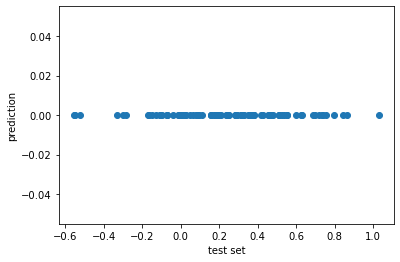

{(0.2, 1.1253517471925912e-07): 0.032793549852373385, (0.2, 8.315287191035679e-07): 0.032793549852373385, (0.2, 6.14421235332821e-06): 0.03251040956923309, (0.2, 4.5399929762484854e-05): 0.036008781891134836, (0.2, 0.00033546262790251185): 0.041886592474827775, (0.2, 0.0024787521766663585): 0.02992807933984405, (0.2, 0.01831563888873418): -0.05472556590203649, (0.2, 0.1353352832366127): -0.066957234007175, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.032793549852373385, (0.2888888888888889, 8.315287191035679e-07): 0.032793549852373385, (0.2888888888888889, 6.14421235332821e-06): 0.032954803543038834, (0.2888888888888889, 4.5399929762484854e-05): 0.036358543417366954, (0.2888888888888889, 0.00033546262790251185): 0.04221061397531986, (0.2888888888888889, 0.0024787521766663585): 0.012201529260352794, (0.2888888888888889, 0.01831563888873418): -0.0878272390037096, (0.2888888888888889, 0.1353352832366127): -0

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


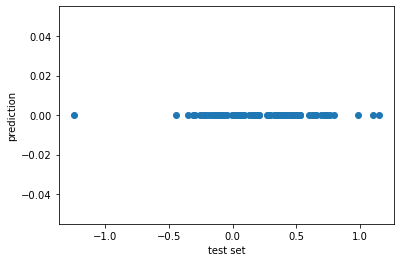

 20%|██        | 2/10 [09:06<36:23, 272.96s/it]

iter 1, outter loop finished. 
iteration 2 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.07304337951396775, (0.2, 8.315287191035679e-07): -0.07304337951396775, (0.2, 6.14421235332821e-06): -0.07284730108259521, (0.2, 4.5399929762484854e-05): -0.0721190097660686, (0.2, 0.00033546262790251185): -0.07574911045499282, (0.2, 0.0024787521766663585): -0.07777424483306836, (0.2, 0.01831563888873418): -0.09287682640623819, (0.2, 0.1353352832366127): -0.004886539600421522, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.07304337951396775, (0.2888888888888889, 8.315287191035679e-07): -0.07284730108259521, (0.2888888888888889, 6.14421235332821e-06): -0.072875312287077, (0.2888888888888889, 4.5399929762484854e-05): -0.0712794306911954, (0.2888888888888889, 0.00033546262790251185): -0.07958058899235369, (0.2888888888888889, 0.0024787521766663585): -0.0832053902642138, (0.2888888888888889, 0.01831563888873418): -0.091747

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


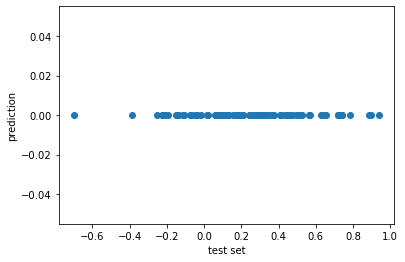

{(0.2, 1.1253517471925912e-07): 0.03524490877432057, (0.2, 8.315287191035679e-07): 0.03524490877432057, (0.2, 6.14421235332821e-06): 0.03492315845257025, (0.2, 4.5399929762484854e-05): 0.03280490574608221, (0.2, 0.00033546262790251185): 0.03758876523582406, (0.2, 0.0024787521766663585): 0.02805511393746688, (0.2, 0.01831563888873418): -0.08217654629419335, (0.2, 0.1353352832366127): 0.02794793180738822, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.03524490877432057, (0.2888888888888889, 8.315287191035679e-07): 0.03524490877432057, (0.2888888888888889, 6.14421235332821e-06): 0.03492315845257025, (0.2888888888888889, 4.5399929762484854e-05): 0.03553940495116964, (0.2888888888888889, 0.00033546262790251185): 0.03692103868574457, (0.2888888888888889, 0.0024787521766663585): 0.015652206828677413, (0.2888888888888889, 0.01831563888873418): -0.09315163903399198, (0.2888888888888889, 0.1353352832366127): -0.00357

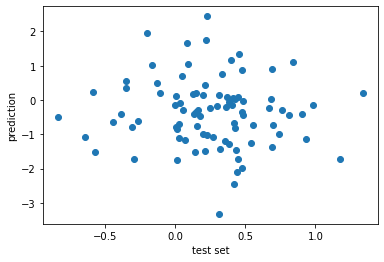

{(0.2, 1.1253517471925912e-07): -0.10694299341358168, (0.2, 8.315287191035679e-07): -0.10750321750321754, (0.2, 6.14421235332821e-06): -0.10728064198652436, (0.2, 4.5399929762484854e-05): -0.10592020592020593, (0.2, 0.00033546262790251185): -0.10662578544931486, (0.2, 0.0024787521766663585): -0.1312650465591642, (0.2, 0.01831563888873418): -0.13614505261564086, (0.2, 0.1353352832366127): -0.099795300040156, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.10694299341358168, (0.2888888888888889, 8.315287191035679e-07): -0.10750321750321754, (0.2888888888888889, 6.14421235332821e-06): -0.10728064198652436, (0.2888888888888889, 4.5399929762484854e-05): -0.10646074646074648, (0.2888888888888889, 0.00033546262790251185): -0.11021803315920967, (0.2888888888888889, 0.0024787521766663585): -0.13556135967900676, (0.2888888888888889, 0.01831563888873418): -0.13373760314936786, (0.2888888888888889, 0.1353352832366127):

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


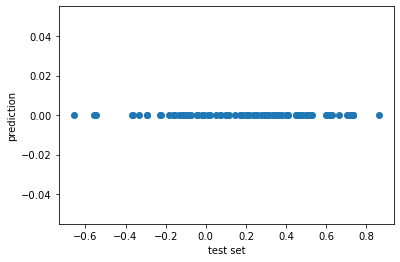

{(0.2, 1.1253517471925912e-07): -0.13942539177833296, (0.2, 8.315287191035679e-07): -0.13942539177833296, (0.2, 6.14421235332821e-06): -0.13942539177833296, (0.2, 4.5399929762484854e-05): -0.13790067378302673, (0.2, 0.00033546262790251185): -0.13362328715269892, (0.2, 0.0024787521766663585): -0.14219698690286925, (0.2, 0.01831563888873418): -0.1371587553940495, (0.2, 0.1353352832366127): -0.06695327420180777, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.13942539177833296, (0.2888888888888889, 8.315287191035679e-07): -0.13942539177833296, (0.2888888888888889, 6.14421235332821e-06): -0.13942539177833296, (0.2888888888888889, 4.5399929762484854e-05): -0.13754031342266634, (0.2888888888888889, 0.00033546262790251185): -0.13434552199258082, (0.2888888888888889, 0.0024787521766663585): -0.14223256870315693, (0.2888888888888889, 0.01831563888873418): -0.12650314179725947, (0.2888888888888889, 0.1353352832366127

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


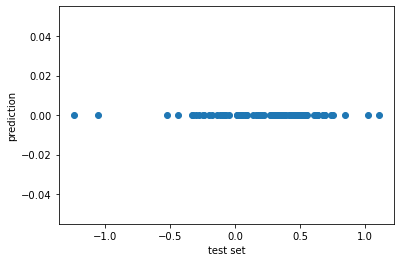

{(0.2, 1.1253517471925912e-07): -0.07834506775683246, (0.2, 8.315287191035679e-07): -0.07834506775683246, (0.2, 6.14421235332821e-06): -0.07817700052994171, (0.2, 4.5399929762484854e-05): -0.07831781361193126, (0.2, 0.00033546262790251185): -0.07935574229691877, (0.2, 0.0024787521766663585): -0.09307290483761074, (0.2, 0.01831563888873418): -0.08921417215534863, (0.2, 0.1353352832366127): 0.02662651070026175, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.07834506775683246, (0.2888888888888889, 8.315287191035679e-07): -0.07834506775683246, (0.2888888888888889, 6.14421235332821e-06): -0.07817700052994171, (0.2888888888888889, 4.5399929762484854e-05): -0.07821561056855174, (0.2888888888888889, 0.00033546262790251185): -0.08071844954197896, (0.2888888888888889, 0.0024787521766663585): -0.0982322658793247, (0.2888888888888889, 0.01831563888873418): -0.08538345067756832, (0.2888888888888889, 0.1353352832366127)

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


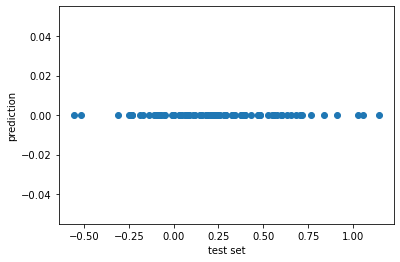

 30%|███       | 3/10 [13:37<31:43, 271.93s/it]

iter 2, outter loop finished. 
iteration 3 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.03879021879021879, (0.2, 8.315287191035679e-07): -0.03879021879021879, (0.2, 6.14421235332821e-06): -0.03854266030736619, (0.2, 4.5399929762484854e-05): -0.03694904989022636, (0.2, 0.00033546262790251185): -0.036433492315845264, (0.2, 0.0024787521766663585): -0.05370883488530548, (0.2, 0.01831563888873418): -0.03259368612309789, (0.2, 0.1353352832366127): 0.1293649424133633, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.03879021879021879, (0.2888888888888889, 8.315287191035679e-07): -0.03879021879021879, (0.2888888888888889, 6.14421235332821e-06): -0.03859868271632977, (0.2888888888888889, 4.5399929762484854e-05): -0.03787341963812552, (0.2888888888888889, 0.00033546262790251185): -0.03708304943599062, (0.2888888888888889, 0.0024787521766663585): -0.057554697554697554, (0.2888888888888889, 0.01831563888873418): -0.02

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


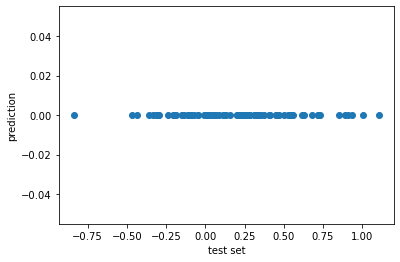

{(0.2, 1.1253517471925912e-07): 0.00895980013627072, (0.2, 8.315287191035679e-07): 0.00842758725111666, (0.2, 6.14421235332821e-06): 0.007755318343553632, (0.2, 4.5399929762484854e-05): 0.006989931107578165, (0.2, 0.00033546262790251185): 0.0046218487394958045, (0.2, 0.0024787521766663585): -0.014392459686577324, (0.2, 0.01831563888873418): -0.09021879021879023, (0.2, 0.1353352832366127): -0.062926212096188, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.00895980013627072, (0.2888888888888889, 8.315287191035679e-07): 0.00842758725111666, (0.2888888888888889, 6.14421235332821e-06): 0.007316223786812018, (0.2888888888888889, 4.5399929762484854e-05): 0.006177606177606179, (0.2888888888888889, 0.00033546262790251185): 0.0013672496025437298, (0.2888888888888889, 0.0024787521766663585): -0.021680672268907568, (0.2888888888888889, 0.01831563888873418): -0.09243773184949655, (0.2888888888888889, 0.1353352832366127)

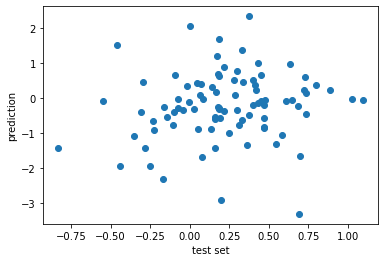

{(0.2, 1.1253517471925912e-07): -0.08132334014686957, (0.2, 8.315287191035679e-07): -0.08132334014686957, (0.2, 6.14421235332821e-06): -0.08076235899765313, (0.2, 4.5399929762484854e-05): -0.08191384661972897, (0.2, 0.00033546262790251185): -0.0782678476796124, (0.2, 0.0024787521766663585): -0.07332500567794686, (0.2, 0.01831563888873418): -0.08751230221818457, (0.2, 0.1353352832366127): -0.029694034163961148, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.08132334014686957, (0.2888888888888889, 8.315287191035679e-07): -0.08132334014686957, (0.2888888888888889, 6.14421235332821e-06): -0.08121053826936182, (0.2888888888888889, 4.5399929762484854e-05): -0.08140888787947613, (0.2888888888888889, 0.00033546262790251185): -0.0773321220380044, (0.2888888888888889, 0.0024787521766663585): -0.06226360814596109, (0.2888888888888889, 0.01831563888873418): -0.09280414868650162, (0.2888888888888889, 0.1353352832366127

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


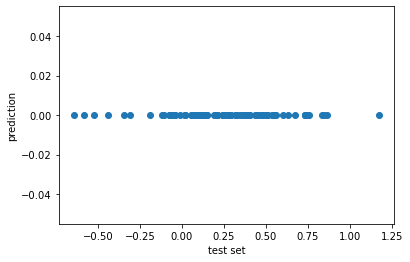

{(0.2, 1.1253517471925912e-07): -0.028031645090468616, (0.2, 8.315287191035679e-07): -0.028031645090468616, (0.2, 6.14421235332821e-06): -0.029068059656294953, (0.2, 4.5399929762484854e-05): -0.02959270194564312, (0.2, 0.00033546262790251185): -0.04260731319554848, (0.2, 0.0024787521766663585): -0.04518888636535696, (0.2, 0.01831563888873418): -0.046294193353016884, (0.2, 0.1353352832366127): 0.07955045677435144, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.028031645090468616, (0.2888888888888889, 8.315287191035679e-07): -0.028031645090468616, (0.2888888888888889, 6.14421235332821e-06): -0.02899083957907488, (0.2888888888888889, 4.5399929762484854e-05): -0.02933454462866228, (0.2888888888888889, 0.00033546262790251185): -0.04364448482095541, (0.2888888888888889, 0.0024787521766663585): -0.043051707169354234, (0.2888888888888889, 0.01831563888873418): -0.029341358164887577, (0.2888888888888889, 0.13533528

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


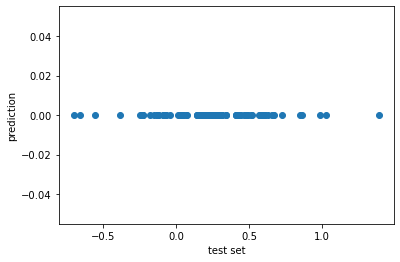

{(0.2, 1.1253517471925912e-07): 0.019574532515708985, (0.2, 8.315287191035679e-07): 0.019574532515708985, (0.2, 6.14421235332821e-06): 0.018986297221591338, (0.2, 4.5399929762484854e-05): 0.01602770838064956, (0.2, 0.00033546262790251185): 0.011598152774623362, (0.2, 0.0024787521766663585): 0.0021477780301309645, (0.2, 0.01831563888873418): -0.06650389885684004, (0.2, 0.1353352832366127): -0.0695320904676169, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.019574532515708985, (0.2888888888888889, 8.315287191035679e-07): 0.019574532515708985, (0.2888888888888889, 6.14421235332821e-06): 0.018958286017109548, (0.2888888888888889, 4.5399929762484854e-05): 0.015637065637065645, (0.2888888888888889, 0.00033546262790251185): 0.010967522143992723, (0.2888888888888889, 0.0024787521766663585): -0.0027450980392156763, (0.2888888888888889, 0.01831563888873418): -0.0944507532742827, (0.2888888888888889, 0.135335283236612

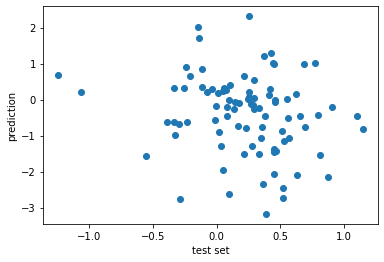

 40%|████      | 4/10 [17:51<26:29, 265.00s/it]

iter 3, outter loop finished. 
iteration 4 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.14172912408206526, (0.2, 8.315287191035679e-07): -0.14172912408206526, (0.2, 6.14421235332821e-06): -0.14172912408206526, (0.2, 4.5399929762484854e-05): -0.14284957226133696, (0.2, 0.00033546262790251185): -0.1431705655235067, (0.2, 0.0024787521766663585): -0.13561056855174503, (0.2, 0.01831563888873418): -0.1026981603452192, (0.2, 0.1353352832366127): -0.0716379142501661, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.14172912408206526, (0.2888888888888889, 8.315287191035679e-07): -0.14172912408206526, (0.2888888888888889, 6.14421235332821e-06): -0.14172912408206526, (0.2888888888888889, 4.5399929762484854e-05): -0.14304565069270953, (0.2888888888888889, 0.00033546262790251185): -0.14072374895904308, (0.2888888888888889, 0.0024787521766663585): -0.12384661972897268, (0.2888888888888889, 0.01831563888873418): -0.09250

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


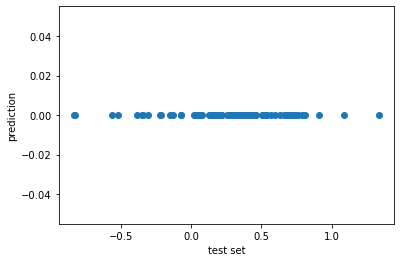

{(0.2, 1.1253517471925912e-07): -0.06813914755091226, (0.2, 8.315287191035679e-07): -0.06813914755091226, (0.2, 6.14421235332821e-06): -0.0680271027329851, (0.2, 4.5399929762484854e-05): -0.06828374593080475, (0.2, 0.00033546262790251185): -0.06199712317359376, (0.2, 0.0024787521766663585): -0.04881293057763646, (0.2, 0.01831563888873418): -0.0647248088424559, (0.2, 0.1353352832366127): -0.002805802351617562, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.06813914755091226, (0.2888888888888889, 8.315287191035679e-07): -0.06813914755091226, (0.2888888888888889, 6.14421235332821e-06): -0.0672564160799455, (0.2888888888888889, 4.5399929762484854e-05): -0.06951623892800363, (0.2888888888888889, 0.00033546262790251185): -0.06164736164736164, (0.2888888888888889, 0.0024787521766663585): -0.04183738360208948, (0.2888888888888889, 0.01831563888873418): -0.05741237035354685, (0.2888888888888889, 0.1353352832366127)

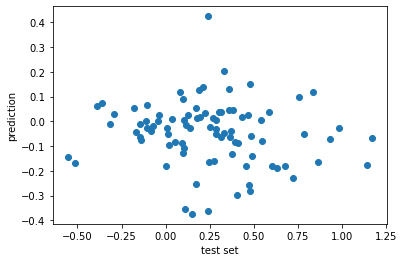

{(0.2, 1.1253517471925912e-07): 0.008340525399348932, (0.2, 8.315287191035679e-07): 0.008340525399348932, (0.2, 6.14421235332821e-06): 0.007696267696267701, (0.2, 4.5399929762484854e-05): 0.009177833295480355, (0.2, 0.00033546262790251185): 0.012061473237943824, (0.2, 0.0024787521766663585): -0.00401014459837989, (0.2, 0.01831563888873418): -0.05534711181770006, (0.2, 0.1353352832366127): 0.06705521322549178, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.008340525399348932, (0.2888888888888889, 8.315287191035679e-07): 0.00811643576349459, (0.2888888888888889, 6.14421235332821e-06): 0.008030888030888035, (0.2888888888888889, 4.5399929762484854e-05): 0.007864334923158453, (0.2888888888888889, 0.00033546262790251185): 0.01056476644711939, (0.2888888888888889, 0.0024787521766663585): -0.0092709516238928, (0.2888888888888889, 0.01831563888873418): -0.047351048527519125, (0.2888888888888889, 0.1353352832366127):

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


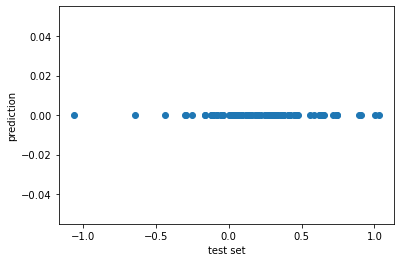

{(0.2, 1.1253517471925912e-07): -0.12025664319781967, (0.2, 8.315287191035679e-07): -0.11989628283745932, (0.2, 6.14421235332821e-06): -0.11928457869634342, (0.2, 4.5399929762484854e-05): -0.11834506775683247, (0.2, 0.00033546262790251185): -0.11693088046029224, (0.2, 0.0024787521766663585): -0.07874706639412522, (0.2, 0.01831563888873418): -0.10256188962071315, (0.2, 0.1353352832366127): -0.031730412743166514, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.12025664319781967, (0.2888888888888889, 8.315287191035679e-07): -0.11989628283745932, (0.2888888888888889, 6.14421235332821e-06): -0.11928457869634342, (0.2888888888888889, 4.5399929762484854e-05): -0.11865319100613218, (0.2888888888888889, 0.00033546262790251185): -0.11632296161707927, (0.2888888888888889, 0.0024787521766663585): -0.08575213869331516, (0.2888888888888889, 0.01831563888873418): -0.11750775986070103, (0.2888888888888889, 0.13533528323661

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


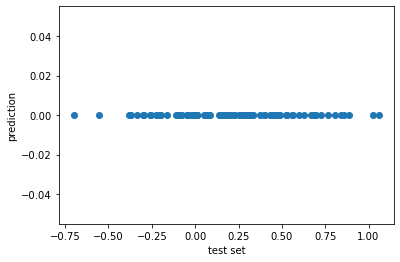

{(0.2, 1.1253517471925912e-07): 0.01811340752517223, (0.2, 8.315287191035679e-07): 0.01811340752517223, (0.2, 6.14421235332821e-06): 0.017809826633356046, (0.2, 4.5399929762484854e-05): 0.018635021576198042, (0.2, 0.00033546262790251185): 0.016151866151866152, (0.2, 0.0024787521766663585): 0.012408963585434177, (0.2, 0.01831563888873418): -0.021087137557725795, (0.2, 0.1353352832366127): -0.02068617811394701, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.01811340752517223, (0.2888888888888889, 8.315287191035679e-07): 0.01811340752517223, (0.2888888888888889, 6.14421235332821e-06): 0.017809826633356046, (0.2888888888888889, 4.5399929762484854e-05): 0.018300401241577717, (0.2888888888888889, 0.00033546262790251185): 0.01354833825422061, (0.2888888888888889, 0.0024787521766663585): 0.011302142478613067, (0.2888888888888889, 0.01831563888873418): -0.024357634945870246, (0.2888888888888889, 0.1353352832366127):

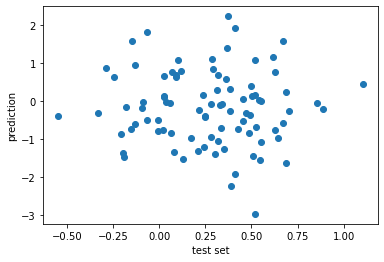

 50%|█████     | 5/10 [22:05<21:45, 261.02s/it]

iter 4, outter loop finished. 
iteration 5 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.010816867287455522, (0.2, 8.315287191035679e-07): -0.010816867287455522, (0.2, 6.14421235332821e-06): -0.010620788856082974, (0.2, 4.5399929762484854e-05): -0.012159890983420393, (0.2, 0.00033546262790251185): -0.01255431902490726, (0.2, 0.0024787521766663585): -0.013962449844802785, (0.2, 0.01831563888873418): -0.07645468998410178, (0.2, 0.1353352832366127): -0.07325106494626152, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.010816867287455522, (0.2888888888888889, 8.315287191035679e-07): -0.010816867287455522, (0.2888888888888889, 6.14421235332821e-06): -0.010620788856082974, (0.2888888888888889, 4.5399929762484854e-05): -0.012328715269891741, (0.2888888888888889, 0.00033546262790251185): -0.010629873571050042, (0.2888888888888889, 0.0024787521766663585): -0.020120372473313646, (0.2888888888888889, 0.01831563888873

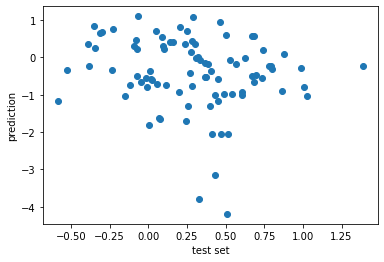

{(0.2, 1.1253517471925912e-07): -0.0353024453024453, (0.2, 8.315287191035679e-07): -0.0353024453024453, (0.2, 6.14421235332821e-06): -0.03542054659701719, (0.2, 4.5399929762484854e-05): -0.03422363540010599, (0.2, 0.00033546262790251185): -0.034642289348171706, (0.2, 0.0024787521766663585): -0.022072072072072072, (0.2, 0.01831563888873418): -0.07049663108486637, (0.2, 0.1353352832366127): -0.031755571022911565, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.0353024453024453, (0.2888888888888889, 8.315287191035679e-07): -0.0353024453024453, (0.2888888888888889, 6.14421235332821e-06): -0.03542054659701719, (0.2888888888888889, 4.5399929762484854e-05): -0.03423272011507306, (0.2888888888888889, 0.00033546262790251185): -0.03587175410704822, (0.2888888888888889, 0.0024787521766663585): -0.016154137330607922, (0.2888888888888889, 0.01831563888873418): -0.08408206525853584, (0.2888888888888889, 0.135335283236612

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


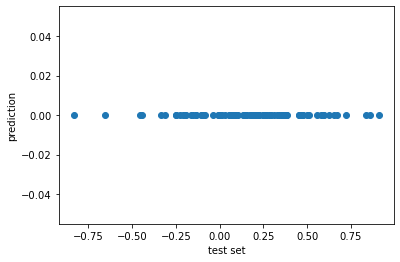

{(0.2, 1.1253517471925912e-07): -0.09196986902869257, (0.2, 8.315287191035679e-07): -0.09129760012112956, (0.2, 6.14421235332821e-06): -0.09104019986372928, (0.2, 4.5399929762484854e-05): -0.09150427738663033, (0.2, 0.00033546262790251185): -0.08771519418578244, (0.2, 0.0024787521766663585): -0.07675599969717617, (0.2, 0.01831563888873418): -0.10979256567491862, (0.2, 0.1353352832366127): -0.011252672757625858, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.09196986902869257, (0.2888888888888889, 8.315287191035679e-07): -0.09129760012112956, (0.2888888888888889, 6.14421235332821e-06): -0.09162843515784694, (0.2888888888888889, 4.5399929762484854e-05): -0.09191838897721252, (0.2888888888888889, 0.00033546262790251185): -0.09008706185176774, (0.2888888888888889, 0.0024787521766663585): -0.07274282686047392, (0.2888888888888889, 0.01831563888873418): -0.11462109167991522, (0.2888888888888889, 0.13533528323661

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


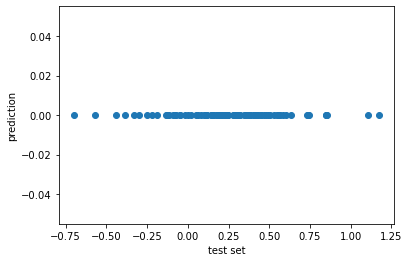

{(0.2, 1.1253517471925912e-07): 0.019507911272617154, (0.2, 8.315287191035679e-07): 0.019507911272617154, (0.2, 6.14421235332821e-06): 0.019984101748807628, (0.2, 4.5399929762484854e-05): 0.018962071315012492, (0.2, 0.00033546262790251185): 0.01663335604512075, (0.2, 0.0024787521766663585): 0.003071390718449536, (0.2, 0.01831563888873418): -0.043596790067378294, (0.2, 0.1353352832366127): -0.153513687199461, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.019507911272617154, (0.2888888888888889, 8.315287191035679e-07): 0.019507911272617154, (0.2888888888888889, 6.14421235332821e-06): 0.019984101748807628, (0.2888888888888889, 4.5399929762484854e-05): 0.019336058747823452, (0.2888888888888889, 0.00033546262790251185): 0.012697403285638587, (0.2888888888888889, 0.0024787521766663585): 0.001211295328942389, (0.2888888888888889, 0.01831563888873418): -0.06507684154742979, (0.2888888888888889, 0.1353352832366127)

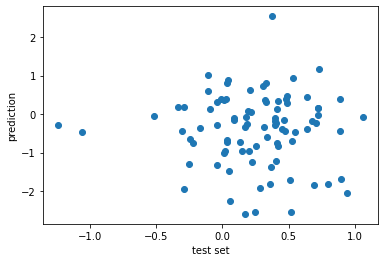

{(0.2, 1.1253517471925912e-07): -0.0012635324400030277, (0.2, 8.315287191035679e-07): -0.0012635324400030277, (0.2, 6.14421235332821e-06): -0.0021598909834203922, (0.2, 4.5399929762484854e-05): -0.001746536452418819, (0.2, 0.00033546262790251185): -0.005087440381558032, (0.2, 0.0024787521766663585): -0.03332879097584981, (0.2, 0.01831563888873418): -0.10827920357332124, (0.2, 0.1353352832366127): -0.10679811410897981, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.0012635324400030277, (0.2888888888888889, 8.315287191035679e-07): -0.0012635324400030277, (0.2888888888888889, 6.14421235332821e-06): -0.0021038685744568077, (0.2888888888888889, 4.5399929762484854e-05): -0.00040805511393747355, (0.2888888888888889, 0.00033546262790251185): -0.010006813536225293, (0.2888888888888889, 0.0024787521766663585): -0.0401165871754107, (0.2888888888888889, 0.01831563888873418): -0.1268158074040427, (0.2888888888888889, 0

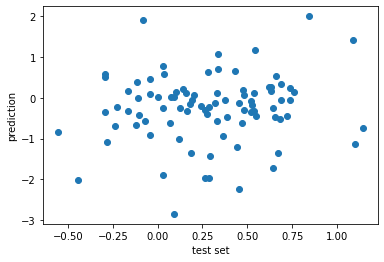

 60%|██████    | 6/10 [47:47<46:26, 696.74s/it]

iter 5, outter loop finished. 
iteration 6 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.09901809372397609, (0.2, 8.315287191035679e-07): -0.09901809372397609, (0.2, 6.14421235332821e-06): -0.09806949806949808, (0.2, 4.5399929762484854e-05): -0.0970641229464759, (0.2, 0.00033546262790251185): -0.09599136952078129, (0.2, 0.0024787521766663585): -0.0878340525399349, (0.2, 0.01831563888873418): -0.10325838443485502, (0.2, 0.1353352832366127): -0.010155800202618488, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.09901809372397609, (0.2888888888888889, 8.315287191035679e-07): -0.09901809372397609, (0.2888888888888889, 6.14421235332821e-06): -0.09806949806949808, (0.2888888888888889, 4.5399929762484854e-05): -0.0971133318192142, (0.2888888888888889, 0.00033546262790251185): -0.09779241426300252, (0.2888888888888889, 0.0024787521766663585): -0.0880664698311757, (0.2888888888888889, 0.01831563888873418): -0.09535

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


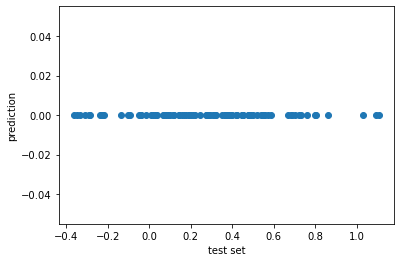

{(0.2, 1.1253517471925912e-07): -0.11340903929139226, (0.2, 8.315287191035679e-07): -0.11427738663032783, (0.2, 6.14421235332821e-06): -0.11432962374138844, (0.2, 4.5399929762484854e-05): -0.11367779544250131, (0.2, 0.00033546262790251185): -0.11915966386554622, (0.2, 0.0024787521766663585): -0.1217889317889318, (0.2, 0.01831563888873418): -0.15873192520251345, (0.2, 0.1353352832366127): -0.17018445455525036, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.11340903929139226, (0.2888888888888889, 8.315287191035679e-07): -0.11427738663032783, (0.2888888888888889, 6.14421235332821e-06): -0.11432962374138844, (0.2888888888888889, 4.5399929762484854e-05): -0.11420849420849422, (0.2888888888888889, 0.00033546262790251185): -0.12059126353244001, (0.2888888888888889, 0.0024787521766663585): -0.1292096297978651, (0.2888888888888889, 0.01831563888873418): -0.17280566280566284, (0.2888888888888889, 0.1353352832366127)

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


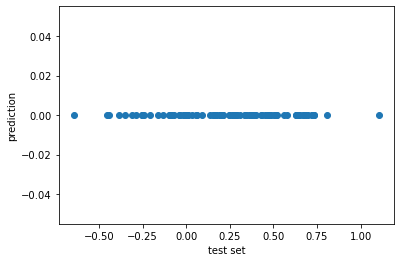

{(0.2, 1.1253517471925912e-07): -0.0212514194867136, (0.2, 8.315287191035679e-07): -0.0212514194867136, (0.2, 6.14421235332821e-06): -0.020971307441895674, (0.2, 4.5399929762484854e-05): -0.02080324021500492, (0.2, 0.00033546262790251185): -0.024466651525475055, (0.2, 0.0024787521766663585): -0.0504194110076463, (0.2, 0.01831563888873418): -0.09837307896131425, (0.2, 0.1353352832366127): 0.012769509815535868, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.0212514194867136, (0.2888888888888889, 8.315287191035679e-07): -0.0212514194867136, (0.2888888888888889, 6.14421235332821e-06): -0.02063517298811417, (0.2888888888888889, 4.5399929762484854e-05): -0.020830494359906127, (0.2888888888888889, 0.00033546262790251185): -0.02817700052994171, (0.2888888888888889, 0.0024787521766663585): -0.05610947081535317, (0.2888888888888889, 0.01831563888873418): -0.10088878794761147, (0.2888888888888889, 0.1353352832366127)

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


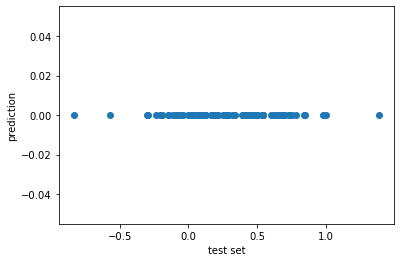

{(0.2, 1.1253517471925912e-07): -0.11444999621470212, (0.2, 8.315287191035679e-07): -0.11444999621470212, (0.2, 6.14421235332821e-06): -0.11537815126050421, (0.2, 4.5399929762484854e-05): -0.11567340449693393, (0.2, 0.00033546262790251185): -0.11340752517223107, (0.2, 0.0024787521766663585): -0.10449541978953743, (0.2, 0.01831563888873418): -0.08954122189416307, (0.2, 0.1353352832366127): -0.07736566927887159, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.11444999621470212, (0.2888888888888889, 8.315287191035679e-07): -0.11444999621470212, (0.2888888888888889, 6.14421235332821e-06): -0.11537815126050421, (0.2888888888888889, 4.5399929762484854e-05): -0.11582330229389055, (0.2888888888888889, 0.00033546262790251185): -0.11306306306306309, (0.2888888888888889, 0.0024787521766663585): -0.10300249829661594, (0.2888888888888889, 0.01831563888873418): -0.08148005148005147, (0.2888888888888889, 0.135335283236612

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


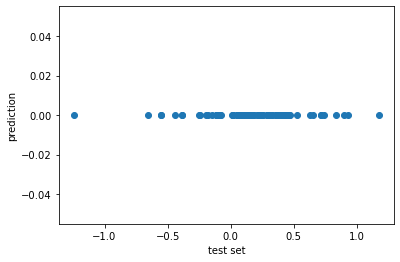

{(0.2, 1.1253517471925912e-07): -0.0698145204027557, (0.2, 8.315287191035679e-07): -0.0698145204027557, (0.2, 6.14421235332821e-06): -0.06945416004239534, (0.2, 4.5399929762484854e-05): -0.07093572564160801, (0.2, 0.00033546262790251185): -0.07300931183284126, (0.2, 0.0024787521766663585): -0.11043455219925806, (0.2, 0.01831563888873418): -0.09387765917177683, (0.2, 0.1353352832366127): -0.09761094203561096, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.0698145204027557, (0.2888888888888889, 8.315287191035679e-07): -0.06945416004239534, (0.2888888888888889, 6.14421235332821e-06): -0.06945416004239534, (0.2888888888888889, 4.5399929762484854e-05): -0.07079566961919906, (0.2888888888888889, 0.00033546262790251185): -0.079451131804073, (0.2888888888888889, 0.0024787521766663585): -0.11440381558028616, (0.2888888888888889, 0.01831563888873418): -0.10034219093042622, (0.2888888888888889, 0.1353352832366127): -

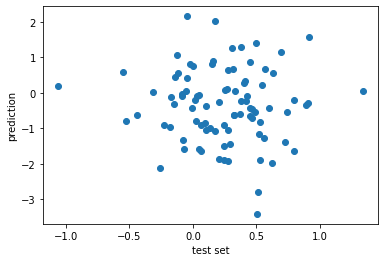

 70%|███████   | 7/10 [52:00<27:34, 551.48s/it]

iter 6, outter loop finished. 
iteration 7 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.1394564312211371, (0.2, 8.315287191035679e-07): -0.1394564312211371, (0.2, 6.14421235332821e-06): -0.13926035278976454, (0.2, 4.5399929762484854e-05): -0.14156484215307746, (0.2, 0.00033546262790251185): -0.15225982284805814, (0.2, 0.0024787521766663585): -0.16586494057082293, (0.2, 0.01831563888873418): -0.12463396169278522, (0.2, 0.1353352832366127): -0.10784686600194633, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.1394564312211371, (0.2888888888888889, 8.315287191035679e-07): -0.1394564312211371, (0.2888888888888889, 6.14421235332821e-06): -0.13926035278976454, (0.2888888888888889, 4.5399929762484854e-05): -0.14267090620031797, (0.2888888888888889, 0.00033546262790251185): -0.14954954954954955, (0.2888888888888889, 0.0024787521766663585): -0.16900598077068665, (0.2888888888888889, 0.01831563888873418): -0.106513

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


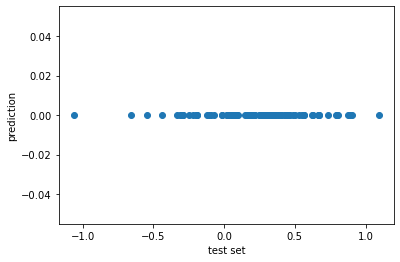

{(0.2, 1.1253517471925912e-07): -0.12650768415474298, (0.2, 8.315287191035679e-07): -0.12650768415474298, (0.2, 6.14421235332821e-06): -0.12650768415474298, (0.2, 4.5399929762484854e-05): -0.12675827087591796, (0.2, 0.00033546262790251185): -0.12312665606783255, (0.2, 0.0024787521766663585): -0.11385343326519796, (0.2, 0.01831563888873418): -0.08950564009387538, (0.2, 0.1353352832366127): -0.03867988361996907, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.12650768415474298, (0.2888888888888889, 8.315287191035679e-07): -0.12650768415474298, (0.2888888888888889, 6.14421235332821e-06): -0.12668786433492316, (0.2888888888888889, 4.5399929762484854e-05): -0.12583995760466352, (0.2888888888888889, 0.00033546262790251185): -0.12761601938072525, (0.2888888888888889, 0.0024787521766663585): -0.1043742902566432, (0.2888888888888889, 0.01831563888873418): -0.09989703989703992, (0.2888888888888889, 0.1353352832366127

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


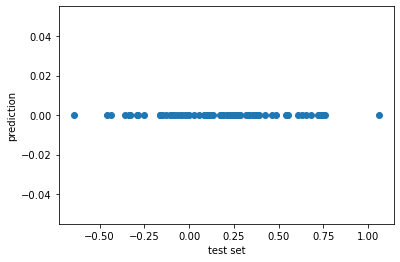

{(0.2, 1.1253517471925912e-07): -0.00796048148989326, (0.2, 8.315287191035679e-07): -0.00796048148989326, (0.2, 6.14421235332821e-06): -0.00754031342266637, (0.2, 4.5399929762484854e-05): -0.008460140813081992, (0.2, 0.00033546262790251185): -0.01959573018396548, (0.2, 0.0024787521766663585): -0.03525399348928761, (0.2, 0.01831563888873418): -0.0483284124460595, (0.2, 0.1353352832366127): 0.005693294569891727, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.00796048148989326, (0.2888888888888889, 8.315287191035679e-07): -0.00796048148989326, (0.2888888888888889, 6.14421235332821e-06): -0.007596335831629955, (0.2888888888888889, 4.5399929762484854e-05): -0.007870391399803167, (0.2888888888888889, 0.00033546262790251185): -0.025285789991672348, (0.2888888888888889, 0.0024787521766663585): -0.03525626466802937, (0.2888888888888889, 0.01831563888873418): -0.055166174577939285, (0.2888888888888889, 0.13533528323

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


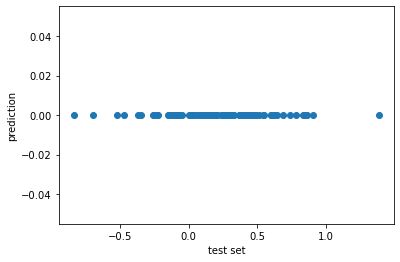

{(0.2, 1.1253517471925912e-07): -0.032461957756075396, (0.2, 8.315287191035679e-07): -0.032461957756075396, (0.2, 6.14421235332821e-06): -0.031767734120675295, (0.2, 4.5399929762484854e-05): -0.032882882882882894, (0.2, 0.00033546262790251185): -0.03150276326746916, (0.2, 0.0024787521766663585): -0.051071996366114016, (0.2, 0.01831563888873418): -0.10527140585964115, (0.2, 0.1353352832366127): -0.00281959050826229, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.032461957756075396, (0.2888888888888889, 8.315287191035679e-07): -0.032461957756075396, (0.2888888888888889, 6.14421235332821e-06): -0.031767734120675295, (0.2888888888888889, 4.5399929762484854e-05): -0.03290029525323644, (0.2888888888888889, 0.00033546262790251185): -0.031837383602089486, (0.2888888888888889, 0.0024787521766663585): -0.0559641153758801, (0.2888888888888889, 0.01831563888873418): -0.09828450299038535, (0.2888888888888889, 0.1353352

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


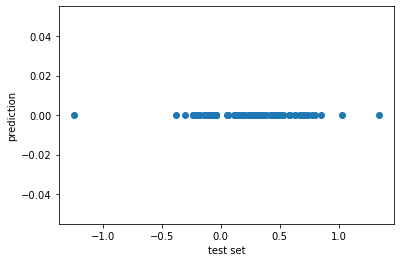

{(0.2, 1.1253517471925912e-07): -0.07501022030433795, (0.2, 8.315287191035679e-07): -0.07501022030433795, (0.2, 6.14421235332821e-06): -0.07537058066469832, (0.2, 4.5399929762484854e-05): -0.07851767734120677, (0.2, 0.00033546262790251185): -0.07984707396472104, (0.2, 0.0024787521766663585): -0.0893337875690817, (0.2, 0.01831563888873418): -0.1800893330305095, (0.2, 0.1353352832366127): -0.15729112477374502, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.07501022030433795, (0.2888888888888889, 8.315287191035679e-07): -0.07501022030433795, (0.2888888888888889, 6.14421235332821e-06): -0.07537058066469832, (0.2888888888888889, 4.5399929762484854e-05): -0.07893633128927247, (0.2888888888888889, 0.00033546262790251185): -0.08046634870164282, (0.2888888888888889, 0.0024787521766663585): -0.0957089862972216, (0.2888888888888889, 0.01831563888873418): -0.17923612688318574, (0.2888888888888889, 0.1353352832366127):

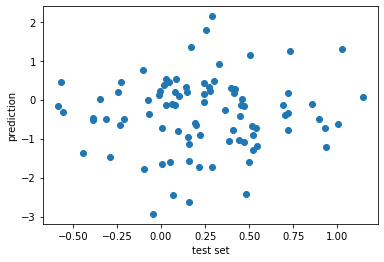

 80%|████████  | 8/10 [56:13<15:12, 456.43s/it]

iter 7, outter loop finished. 
iteration 8 begains
0
0
{(0.2, 1.1253517471925912e-07): 0.061351351351351356, (0.2, 8.315287191035679e-07): 0.06084714967067908, (0.2, 6.14421235332821e-06): 0.06138769021121961, (0.2, 4.5399929762484854e-05): 0.06172155348625937, (0.2, 0.00033546262790251185): 0.05462487697781815, (0.2, 0.0024787521766663585): 0.010687410099174812, (0.2, 0.01831563888873418): -0.10136573548338254, (0.2, 0.1353352832366127): -0.13248605031029265, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.061351351351351356, (0.2888888888888889, 8.315287191035679e-07): 0.06084714967067908, (0.2888888888888889, 6.14421235332821e-06): 0.06169581346051933, (0.2888888888888889, 4.5399929762484854e-05): 0.06107729578317813, (0.2888888888888889, 0.00033546262790251185): 0.056508441214323565, (0.2888888888888889, 0.0024787521766663585): 0.002282534635475804, (0.2888888888888889, 0.01831563888873418): -0.104713452

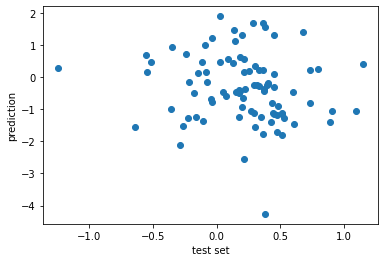

{(0.2, 1.1253517471925912e-07): -0.07505640093875389, (0.2, 8.315287191035679e-07): -0.07505640093875389, (0.2, 6.14421235332821e-06): -0.07477628889393596, (0.2, 4.5399929762484854e-05): -0.07391626921038685, (0.2, 0.00033546262790251185): -0.07765841471723826, (0.2, 0.0024787521766663585): -0.10068816715875542, (0.2, 0.01831563888873418): -0.1687281399046105, (0.2, 0.1353352832366127): -0.037669773945818906, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.07505640093875389, (0.2888888888888889, 8.315287191035679e-07): -0.07505640093875389, (0.2888888888888889, 6.14421235332821e-06): -0.07477628889393596, (0.2888888888888889, 4.5399929762484854e-05): -0.0739965175259293, (0.2888888888888889, 0.00033546262790251185): -0.0821674615792263, (0.2888888888888889, 0.0024787521766663585): -0.10824665001135592, (0.2888888888888889, 0.01831563888873418): -0.1695336512983572, (0.2888888888888889, 0.1353352832366127):

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


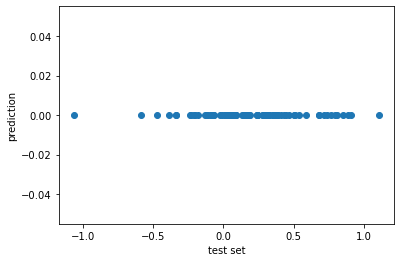

{(0.2, 1.1253517471925912e-07): -0.033471118177000526, (0.2, 8.315287191035679e-07): -0.033471118177000526, (0.2, 6.14421235332821e-06): -0.033471118177000526, (0.2, 4.5399929762484854e-05): -0.03355742296918767, (0.2, 0.00033546262790251185): -0.040409569233098644, (0.2, 0.0024787521766663585): -0.05580740404269817, (0.2, 0.01831563888873418): -0.10578999167234462, (0.2, 0.1353352832366127): -0.13226128000555842, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.033471118177000526, (0.2888888888888889, 8.315287191035679e-07): -0.033471118177000526, (0.2888888888888889, 6.14421235332821e-06): -0.033471118177000526, (0.2888888888888889, 4.5399929762484854e-05): -0.03425921720039367, (0.2888888888888889, 0.00033546262790251185): -0.04268150503444622, (0.2888888888888889, 0.0024787521766663585): -0.049472329472329477, (0.2888888888888889, 0.01831563888873418): -0.12246574305397837, (0.2888888888888889, 0.1353352

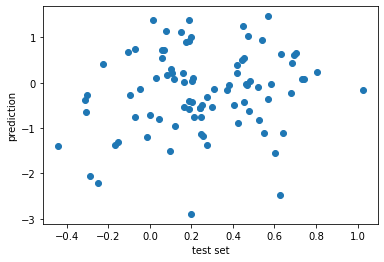

{(0.2, 1.1253517471925912e-07): 0.017519872813990468, (0.2, 8.315287191035679e-07): 0.017519872813990468, (0.2, 6.14421235332821e-06): 0.016684836096600802, (0.2, 4.5399929762484854e-05): 0.017059580588992353, (0.2, 0.00033546262790251185): 0.017866606101900225, (0.2, 0.0024787521766663585): 0.0020902415020062027, (0.2, 0.01831563888873418): -0.04329093799682034, (0.2, 0.1353352832366127): -0.10083245052068628, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): 0.017519872813990468, (0.2888888888888889, 8.315287191035679e-07): 0.017519872813990468, (0.2888888888888889, 6.14421235332821e-06): 0.016684836096600802, (0.2888888888888889, 4.5399929762484854e-05): 0.017373760314936783, (0.2888888888888889, 0.00033546262790251185): 0.015751381633734577, (0.2888888888888889, 0.0024787521766663585): -0.000894087364675597, (0.2888888888888889, 0.01831563888873418): -0.04067529714588537, (0.2888888888888889, 0.1353352832366

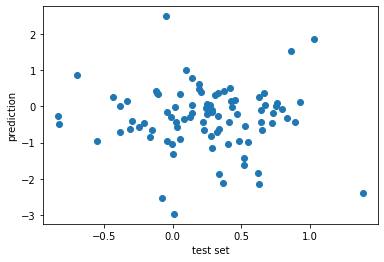

{(0.2, 1.1253517471925912e-07): -0.06415777121659474, (0.2, 8.315287191035679e-07): -0.06415777121659474, (0.2, 6.14421235332821e-06): -0.06415777121659474, (0.2, 4.5399929762484854e-05): -0.06551290786584904, (0.2, 0.00033546262790251185): -0.07875009463244757, (0.2, 0.0024787521766663585): -0.11447043682337803, (0.2, 0.01831563888873418): -0.17033916269210386, (0.2, 0.1353352832366127): -0.00451381911848425, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.06415777121659474, (0.2888888888888889, 8.315287191035679e-07): -0.06415777121659474, (0.2888888888888889, 6.14421235332821e-06): -0.06376561435384966, (0.2888888888888889, 4.5399929762484854e-05): -0.06610417139828903, (0.2888888888888889, 0.00033546262790251185): -0.08377999848588084, (0.2888888888888889, 0.0024787521766663585): -0.12492542963131197, (0.2888888888888889, 0.01831563888873418): -0.18985994397759104, (0.2888888888888889, 0.135335283236612

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


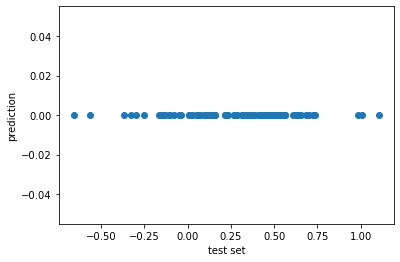

 90%|█████████ | 9/10 [1:10:15<09:37, 577.05s/it]

iter 8, outter loop finished. 
iteration 9 begains
0
0
{(0.2, 1.1253517471925912e-07): -0.03293360587478235, (0.2, 8.315287191035679e-07): -0.03293360587478235, (0.2, 6.14421235332821e-06): -0.03301082595200243, (0.2, 4.5399929762484854e-05): -0.03261866908925732, (0.2, 0.00033546262790251185): -0.0350760844878492, (0.2, 0.0024787521766663585): -0.07419486713604362, (0.2, 0.01831563888873418): -0.07933681580740407, (0.2, 0.1353352832366127): -0.10413954013457534, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.03293360587478235, (0.2888888888888889, 8.315287191035679e-07): -0.03293360587478235, (0.2888888888888889, 6.14421235332821e-06): -0.03301082595200243, (0.2888888888888889, 4.5399929762484854e-05): -0.03236656824892119, (0.2888888888888889, 0.00033546262790251185): -0.03673101673101674, (0.2888888888888889, 0.0024787521766663585): -0.0817949882655765, (0.2888888888888889, 0.01831563888873418): -0.0715

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


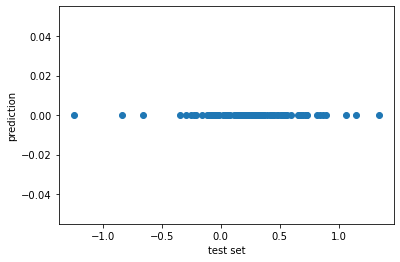

{(0.2, 1.1253517471925912e-07): -0.02776743129684307, (0.2, 8.315287191035679e-07): -0.02776743129684307, (0.2, 6.14421235332821e-06): -0.02776743129684307, (0.2, 4.5399929762484854e-05): -0.027713680066621244, (0.2, 0.00033546262790251185): -0.023686880157468393, (0.2, 0.0024787521766663585): 0.01329850859262624, (0.2, 0.01831563888873418): 0.05210613975319859, (0.2, 0.1353352832366127): 0.015599374798636084, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.02776743129684307, (0.2888888888888889, 8.315287191035679e-07): -0.02776743129684307, (0.2888888888888889, 6.14421235332821e-06): -0.02776743129684307, (0.2888888888888889, 4.5399929762484854e-05): -0.028021803315920968, (0.2888888888888889, 0.00033546262790251185): -0.021054583995760465, (0.2888888888888889, 0.0024787521766663585): 0.016938451056098112, (0.2888888888888889, 0.01831563888873418): 0.0509084714967068, (0.2888888888888889, 0.135335283236612

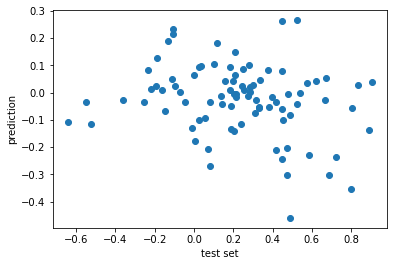

{(0.2, 1.1253517471925912e-07): -0.0030153683094859577, (0.2, 8.315287191035679e-07): -0.0033499886441062917, (0.2, 6.14421235332821e-06): -0.0033499886441062917, (0.2, 4.5399929762484854e-05): -0.002818532818532819, (0.2, 0.00033546262790251185): -0.009060489060489058, (0.2, 0.0024787521766663585): -0.047915814974638496, (0.2, 0.01831563888873418): -0.10290710878946174, (0.2, 0.1353352832366127): -0.0037869584079027628, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.0033499886441062917, (0.2888888888888889, 8.315287191035679e-07): -0.0033499886441062917, (0.2888888888888889, 6.14421235332821e-06): -0.0033499886441062917, (0.2888888888888889, 4.5399929762484854e-05): -0.0031546672723143307, (0.2888888888888889, 0.00033546262790251185): -0.009947762888939355, (0.2888888888888889, 0.0024787521766663585): -0.05495495495495495, (0.2888888888888889, 0.01831563888873418): -0.08855401620107502, (0.288888888888888

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


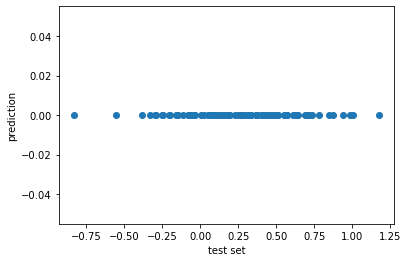

{(0.2, 1.1253517471925912e-07): -0.051763948822772354, (0.2, 8.315287191035679e-07): -0.051763948822772354, (0.2, 6.14421235332821e-06): -0.05027935498523735, (0.2, 4.5399929762484854e-05): -0.050172609584374285, (0.2, 0.00033546262790251185): -0.05290483761071997, (0.2, 0.0024787521766663585): -0.04771822242410477, (0.2, 0.01831563888873418): -0.03230751760163524, (0.2, 0.1353352832366127): 0.016376007820732917, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.051763948822772354, (0.2888888888888889, 8.315287191035679e-07): -0.051231735937618296, (0.2888888888888889, 6.14421235332821e-06): -0.05039139980316452, (0.2888888888888889, 4.5399929762484854e-05): -0.052208342796578086, (0.2888888888888889, 0.00033546262790251185): -0.05484291013702778, (0.2888888888888889, 0.0024787521766663585): -0.04395109395109395, (0.2888888888888889, 0.01831563888873418): -0.027070936482701192, (0.2888888888888889, 0.13533528

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


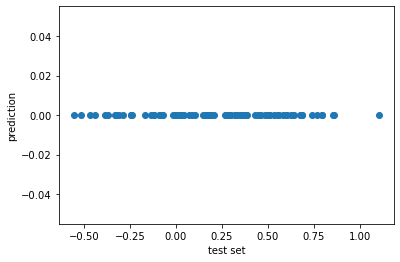

{(0.2, 1.1253517471925912e-07): -0.05133545310015898, (0.2, 8.315287191035679e-07): -0.05133545310015898, (0.2, 6.14421235332821e-06): -0.05141948671360437, (0.2, 4.5399929762484854e-05): -0.05320841850253616, (0.2, 0.00033546262790251185): -0.06175713528654705, (0.2, 0.0024787521766663585): -0.10488076311605725, (0.2, 0.01831563888873418): -0.12997804527216295, (0.2, 0.1353352832366127): -0.02995309599969508, (0.2, 1.0): nan, (0.2, 7.38905609893065): nan, (0.2, 54.598150033144236): nan, (0.2888888888888889, 1.1253517471925912e-07): -0.05133545310015898, (0.2888888888888889, 8.315287191035679e-07): -0.05133545310015898, (0.2888888888888889, 6.14421235332821e-06): -0.05141948671360437, (0.2888888888888889, 4.5399929762484854e-05): -0.05455598455598457, (0.2888888888888889, 0.00033546262790251185): -0.06385873268226208, (0.2888888888888889, 0.0024787521766663585): -0.11439851616322205, (0.2888888888888889, 0.01831563888873418): -0.1291255961844197, (0.2888888888888889, 0.1353352832366127

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


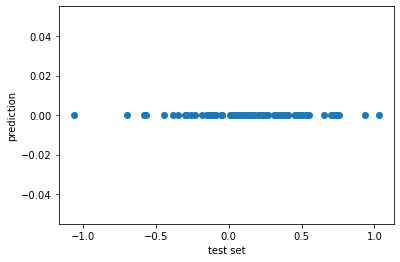

100%|██████████| 10/10 [2:17:10<00:00, 823.05s/it] 

iter 9, outter loop finished. 


In [16]:
for index, (drug_name, drug_index) in enumerate(list(zip(drug_id_list, [np.where(drug_data.columns == drug_id) for drug_id in drug_id_list]))):
    if index == 3:
        result = drug_model(comp_index = int(drug_index[0]), m_file = m_file, drug_data=drug_data,
                       out_path= out_path)
    #pre_matrix = pd.concat([pre_matrix, result], axis = 1)
    

    
    

In [ ]:
if __name__ == '__main__':
    main()

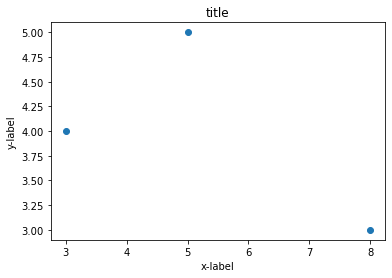

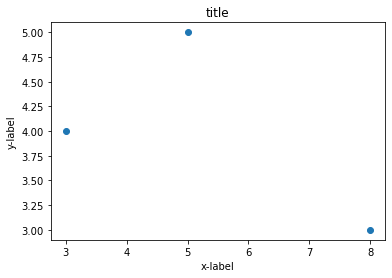

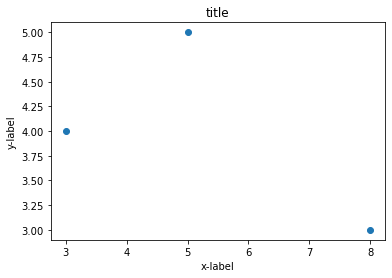

In [13]:

for i in range(3):
    
    x= [8,3,5]; y = [3,4,5]
    plt.scatter(x,y)
    plt.title("title")
    plt.xlabel("x-label")
    plt.ylabel("y-label")
    plt.show()

